In [1]:
# Install required libraries
!pip install yfinance timesfm

  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7

In [1]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [2]:
# Load TimesFM model
timesfm_backend = "gpu"  # or 'cpu'
from jax._src import config
config.update("jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend])

In [21]:
import yfinance as yf
import pandas as pd

# دانلود داده‌های سهام
ticker = 'AAPL'
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")

# بازنمونه‌گیری (resample) به صورت روزانه و پر کردن مقادیر گمشده
data_resampled = data.resample('1D').ffill()

# تبدیل به DataFrame و تنظیم فرمت نهایی
df = data_resampled[['Close']].reset_index()
df.columns = ['date', 'close']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df


[*********************100%%**********************]  1 of 1 completed


,close
date,
2023-01-03,125.070000
2023-01-04,126.360001
2023-01-05,125.019997
2023-01-06,129.619995
2023-01-07,129.619995
...,...
2023-12-25,193.600006
2023-12-26,193.050003
2023-12-27,193.149994


In [10]:


def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [5]:
import timesfm


context_len=64
input_patch_len=32
horizon_len=1
batch_size=1


model = timesfm.TimesFm(
    context_len=context_len,
    horizon_len=horizon_len,
    input_patch_len=input_patch_len,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend=timesfm_backend,
)
model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 3.76 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.96 seconds.
Jitting decoding.
Jitted decoding in 22.31 seconds.


In [20]:
      input_data = get_batched_data_fn(batch_size=batch_size, context_len=context_len, horizon_len=horizon_len)
      metrics = defaultdict(list)
      results = []

      # Process in smaller sub-batches
      for i, example in enumerate(input_data()):
          raw_forecast, _ = model.forecast(
              inputs=example["inputs"], freq=[0] * len(example["inputs"])
          )

          for j in range(len(example["inputs"])):
              result = {
                  'input_index': j,
                  'train_start_date': str(example["dates"][j][0]),
                  'train_end_date': str(example["dates"][j][-2]),
                  'predict_date': str(example["dates"][j][-1]),
                  'raw_forecast': raw_forecast[j][0],
                  'y_actual': example["outputs"][j][0],
                  'batch_size': batch_size,
                  'context_len': context_len,
                  'input_patch_len': input_patch_len
              }
              results.append(result)

In [22]:
 results_df = pd.DataFrame(results)
 results_df

,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,batch_size,context_len,input_patch_len
0,0,2023-01-03 00:00:00,2023-03-07 00:00:00,2023-03-08 00:00:00,152.566696,152.869995,1,64,32
1,0,2023-01-04 00:00:00,2023-03-08 00:00:00,2023-03-09 00:00:00,153.315887,150.589996,1,64,32
2,0,2023-01-05 00:00:00,2023-03-09 00:00:00,2023-03-10 00:00:00,151.186523,148.500000,1,64,32
3,0,2023-01-06 00:00:00,2023-03-10 00:00:00,2023-03-11 00:00:00,149.242218,148.500000,1,64,32
4,0,2023-01-07 00:00:00,2023-03-11 00:00:00,2023-03-12 00:00:00,148.789383,148.500000,1,64,32
...,...,...,...,...,...,...,...,...,...
291,0,2023-10-21 00:00:00,2023-12-23 00:00:00,2023-12-24 00:00:00,193.560013,193.600006,1,64,32
292,0,2023-10-22 00:00:00,2023-12-24 00:00:00,2023-12-25 00:00:00,193.652313,193.600006,1,64,32
293,0,2023-10-23 00:00:00,2023-12-25 00:00:00,2023-12-26 00:00:00,193.921982,193.050003,1,64,32
294,0,2023-10-24 00:00:00,2023-12-26 00:00:00,2023-12-27 00:00:00,193.380096,193.149994,1,64,32


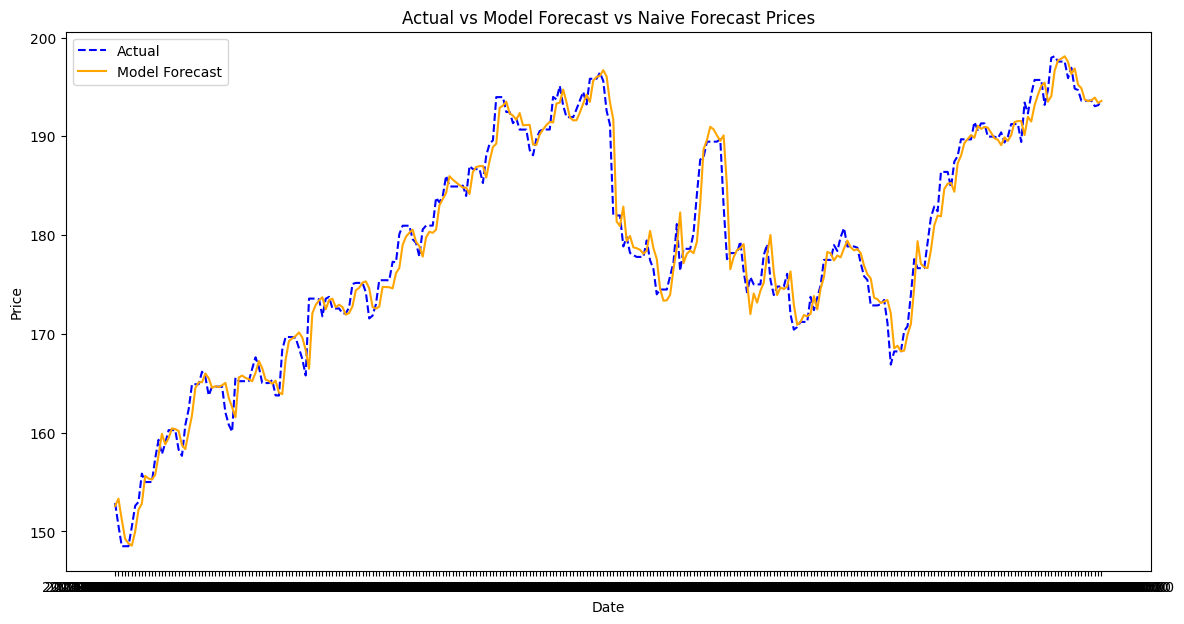

In [24]:
plt.figure(figsize=(14, 7))
plt.plot(results_df['predict_date'], results_df['y_actual'], label='Actual', color='blue', linestyle='--')
plt.plot(results_df['predict_date'], results_df['raw_forecast'], label='Model Forecast', color='orange')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Model Forecast vs Naive Forecast Prices')
plt.legend()
plt.show()

In [25]:
initial_investment = 100
initial_price = results_df['y_actual'].iloc[0]
final_price = results_df['y_actual'].iloc[-1]


# Calculate the number of shares bought initially
shares_bought = initial_investment / initial_price

# Calculate the final value of the investment
final_investment_value = shares_bought * final_price

# Calculate the total profit
buy_and_hold_profit = final_investment_value - initial_investment
buy_and_hold_profit

26.630475576753682

In [26]:
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score

def calculate_mse(context_results_df):
    return mean_squared_error(context_results_df['y_actual'], context_results_df['raw_forecast'])

def calculate_accuracy(context_results_df):
    correct_predictions = 0
    total_predictions = 0
    for i in range(1, len(context_results_df)):
        actual_today = context_results_df['y_actual'].iloc[i]
        predicted_today = context_results_df['raw_forecast'].iloc[i]
        actual_yesterday = context_results_df['y_actual'].iloc[i - 1]
        actual_movement = actual_today - actual_yesterday
        predicted_movement = predicted_today - actual_yesterday
        if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
            correct_predictions += 1
        total_predictions += 1

    return correct_predictions / total_predictions if total_predictions > 0 else 0

def calculate_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(1, len(context_results_df)):
        today_price = context_results_df['y_actual'].iloc[i]
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_actual_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_accuracy(context_results_df):
    def get_direction(current_price, next_price):
        return 1 if next_price > current_price else 0

    real_directions = []
    predicted_directions = []

    for i in range(1, len(context_results_df)):
        real_directions.append(get_direction(context_results_df['y_actual'].iloc[i - 1], context_results_df['y_actual'].iloc[i]))
        predicted_directions.append(get_direction(context_results_df['raw_forecast'].iloc[i - 1], context_results_df['raw_forecast'].iloc[i]))

    return accuracy_score(real_directions, predicted_directions)

def calculate_direction_profit(context_results_df, initial_capital=100):
    capital = initial_capital
    position = 0

    for i in range(2, len(context_results_df)):
        yesterday_price = context_results_df['y_actual'].iloc[i - 1]
        yesterday_predicted_today_price = context_results_df['raw_forecast'].iloc[i - 1]
        predicted_today_price = context_results_df['raw_forecast'].iloc[i]

        if predicted_today_price > yesterday_predicted_today_price:
            if position == 0:
                position = capital / yesterday_price
                capital = 0
        elif predicted_today_price < yesterday_predicted_today_price:
            if position > 0:
                capital = position * yesterday_price
                position = 0

    if position > 0:
        capital = position * context_results_df.iloc[-1]['y_actual']

    return capital - initial_capital

def calculate_results_for_context_len(context_len, results_by_context_len):
    # فیلتر کردن داده‌ها برای context_len مشخص شده
    context_results_df =results_by_context_len

    mse_value = calculate_mse(context_results_df)
    accuracy_value = calculate_accuracy(context_results_df)
    profit = calculate_profit(context_results_df)
    direction_accuracy = calculate_direction_accuracy(context_results_df)
    actual_direction_accuracy = calculate_actual_direction_accuracy(context_results_df)
    direction_profit = calculate_direction_profit(context_results_df)

    # ساخت دیکشنری از نتایج محاسبه شده
    result = {
        'context_len': context_len,
        'mse': mse_value,
        'accuracy': accuracy_value,
        'direction_accuracy': direction_accuracy,
        'actual_direction_accuracy': actual_direction_accuracy,
        'direction_profit': direction_profit,
        'profit': profit
    }

    return pd.DataFrame([result])

# فراخوانی تابع برای یک context_len خاص
context_len = 64  # برای مثال
final_result_df = calculate_results_for_context_len(context_len, results_df)
print(final_result_df)


   context_len       mse  accuracy  direction_accuracy  \
0           64  3.659856  0.366102            0.488136   

   actual_direction_accuracy  direction_profit     profit  
0                   0.505085         14.153186  12.197808  
